In [0]:
# Connect with Google Drive
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
import sys
folder_url = "/gdrive/My Drive/Colab Notebooks/Data/DSP Final/"
sys.path.append(folder_url)
!pip install ffmpeg-python
from voice_recording import record
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
import scipy.signal
!pip install librosa
import librosa #pip install librosa
from librosa import stft, istft
from librosa.core import amplitude_to_db, db_to_amplitude
import IPython
import os
import time
from joblib import dump, load

In [0]:
#Voice recording. Speak one of these words: up, off. Other words (may work): yes, no, stop, go, on, down, left, right
record_rate, record_audio = record(1)
print('record rate', record_rate)
IPython.display.Audio(data=record_audio, rate=record_rate)

Speak Now...


<IPython.core.display.Javascript object>

Done Recording !
record rate 48000


In [0]:
FIXED_LENGTH = 10000 #10000
CUT_LENGTH = 2000 #2000

## Load data
#signal
source_data = record_audio
source_rate = record_rate
source_data = source_data / max(source_data)

FIXED_RATE = source_rate * FIXED_LENGTH/len(source_data)
#FIXED_RATE = source_rate
print('fixed rate',FIXED_RATE)
source_data = librosa.resample(source_data, source_rate, FIXED_RATE)
print('source_data', len(source_data))

#noise
noise_file = folder_url + "cafe_short.wav"
noise_rate, noise_data = wavfile.read(noise_file)
noise_data = noise_data / max(noise_data)
noise_data = librosa.resample(noise_data, noise_rate, FIXED_RATE)
print('noise_data', len(noise_data))

noise_clip = noise_data[: len(source_data)]
noise_add = noise_data[len(source_data) : len(source_data)*2]
#noise_add = noise_clip

# apply noise
audio_clip = source_data + noise_clip

#IPython.display.Audio(data=source_data, rate=source_rate)
#IPython.display.Audio(data=noise_clip, rate=noise_rate)
IPython.display.Audio(data=audio_clip, rate=FIXED_RATE)

fixed rate 5208.333333333333
source_data 10000
noise_data 23685


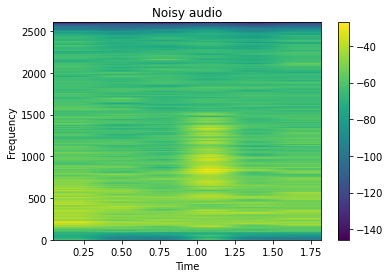

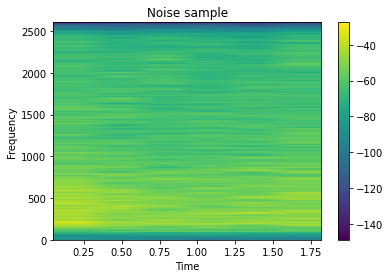

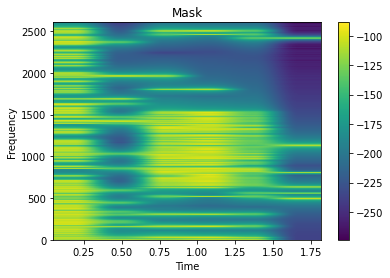

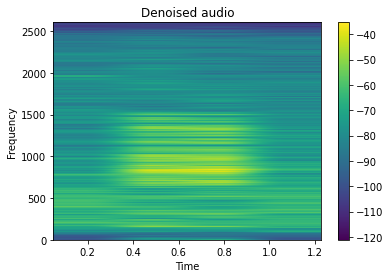

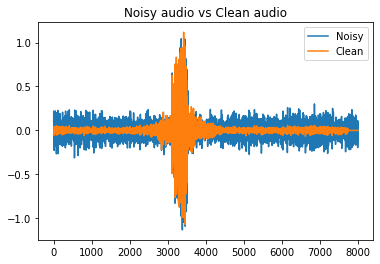

In [0]:
def plot_specgram(signal, title, nfft, rate, hop_size):
    fig, ax = plt.subplots()
    spec, freqs, t, axes_image = ax.specgram(signal, NFFT=nfft, Fs=rate ,noverlap=hop_size, mode='magnitude', scale='dB')
    ax.set_title(title)
    ax.set_xlabel('Time')
    ax.set_ylabel('Frequency')
    fig.colorbar(axes_image)
    plt.show()
    return spec, freqs, t


def de_noise(audio_clip, audio_rate, noise_clip, noise_reduce, nfft=2048, win_size=2048, hop_size=512):
    # Noise STFT
    noise_stft = stft(noise_clip, nfft, hop_size, win_size)
    noise_stft_db = amplitude_to_db(np.abs(noise_stft))
    
    # Noise statistics
    noise_mean_freq = np.mean(noise_stft_db, axis=1)
    noise_std_freq = np.std(noise_stft_db, axis=1)
    noise_threshold = noise_mean_freq + noise_std_freq * 2

    # Signal STFT
    signal_stft = stft(audio_clip, nfft, hop_size, win_size)
    signal_stft_db = amplitude_to_db(np.abs(signal_stft))

    # threshold dB to remove noise
    db_threshold = np.repeat(np.reshape(noise_threshold, [1, len(noise_mean_freq)]), np.shape(signal_stft_db)[1], axis=0).T
    
    # mask if signal is below threshold
    mask = signal_stft_db < db_threshold

    # how much noise to reduce
    mask = mask * noise_reduce

    # dB value to replace noise
    mask_db_value = np.min(amplitude_to_db(np.abs(signal_stft)))

    # mask real
    signal_real_masked = signal_stft_db * (1 - mask) + np.ones(np.shape(mask_db_value)) * mask_db_value * mask  
    
    # mask imaginary
    signal_imag_masked = np.imag(signal_stft) * (1 - mask)

    # combine real & imaginary mask
    signal_stft_amplitude = db_to_amplitude(signal_real_masked) * np.sign(signal_stft) + 1j * signal_imag_masked

    # convert the masked signal back to time domain
    clean_signal = istft(signal_stft_amplitude, hop_size, win_size)

    #pad 0s at end of signal to make it same length as original audio clip
    pads = np.repeat([0],len(audio_clip) - len(clean_signal))
    clean_signal = np.concatenate((clean_signal, pads))
    clean_signal = clean_signal[CUT_LENGTH:]

    #Plot results
    plot_specgram(audio_clip, 'Noisy audio', nfft, audio_rate, hop_size)
    plot_specgram(noise_clip, 'Noise sample', nfft, audio_rate, hop_size)
    mask_normal = istft(db_to_amplitude(mask), hop_size, win_size)
    plot_specgram(mask_normal, 'Mask', nfft, audio_rate, hop_size)
    plot_specgram(clean_signal, 'Denoised audio', nfft, audio_rate, hop_size)

    return clean_signal

#denoise
clean_audio = de_noise(audio_clip, FIXED_RATE, noise_clip, 0.7) #up 0.7 - off 0.7 

#plot results
plt.plot(audio_clip[CUT_LENGTH:])
plt.plot(clean_audio)
plt.title("Noisy audio vs Clean audio")
plt.legend(('Noisy','Clean'))
plt.show()

IPython.display.Audio(data=clean_audio, rate=FIXED_RATE)

In [0]:
#Prediction
model = load(folder_url + 'model.joblib')
classes = load(folder_url + 'classes.joblib')

def predict(model, classes, audio):
    audio = audio.reshape(1,8000,1)
    class_probs = model.predict(audio)
    best_index = np.argmax(class_probs[0])
    pred_class = classes[best_index]
    return pred_class

print("Original audio:", predict(model, classes, source_data[CUT_LENGTH:]))
print("Noisy audio:", predict(model, classes, audio_clip[CUT_LENGTH:]))
print("Denoised audio:", predict(model, classes, clean_audio))

Original audio: up
Noisy audio: up
Denoised audio: up
